In [1]:
import cv2
import json
from src.utils.func import (crop_center, read_image_as_numpyimage)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config
from src.utils.metrics import iou, _reorder_pts
from src.utils.intersections import compute_intersections
from src.utils.annotations import transform_annotation
from pathlib import Path
import pandas as pd
from src.utils.annotations import PolygonAnnotation
import matplotlib.pyplot as plt

In [2]:
picname = 'pic_08_23_02'  # pic_08_23_02          pic_05_63_01    pic_07_39_02
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

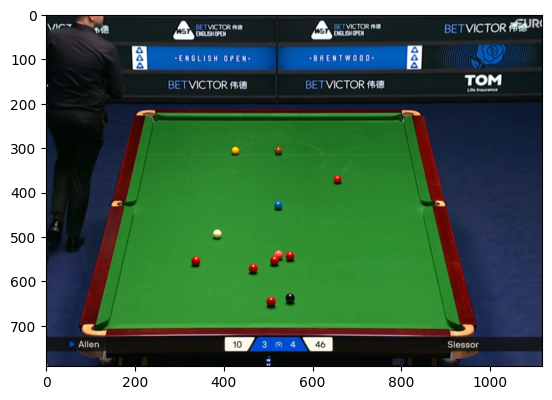

In [3]:
display_img(pic)

In [4]:
finder = PlayfieldFinder(pic)

In [5]:
# internal_top_cushion, bin_roi = finder.find_top_internal_cushion()
internal_top_cushion = finder.find_top_internal_cushion()
internal_top_cushion

y = 0.0 * x + 231.0

In [6]:
# pd.set_option('display.max_columns', None)
# pd.DataFrame(bin_roi)

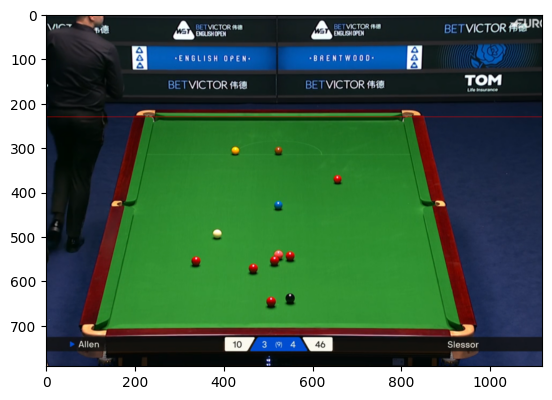

In [7]:
display_img(plot_on_image(pic, lines=[internal_top_cushion], line_thickness=1))

In [8]:
polygon_annp = PolygonAnnotation(root_dir='playfield_gt')
polygon_annp.read(Path('playfield_gt/all.json'))

#### find playfield

In [9]:
root = Path('pics')
results = []
ious = []
pic_names = []
for file in sorted(root.glob('*.png')):
    # print(file.stem)
    pic = read_image_as_numpyimage(file, 'rgb')
    finder = PlayfieldFinder(pic)
    internal_line = None
    y_ref = None
    data = polygon_annp.filter_by_image(file.name)
    if data is None:
        print(file.name)
        
    else:
        points_gt = np.asarray(transform_annotation(pic, data.points))
        y_coords = points_gt[:, 1]
        y_ref = int(np.median(np.sort(y_coords)[:2]))

    try:
        internal_line = finder.find_top_internal_cushion()
        pts = internal_line.limit_to_img(pic)
        pic_copy = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
        cv2.line(pic_copy, *pts, (255, 0, 0), 1)
        cv2.imwrite(f'tests/top_line_tests/test_{file.stem}.png', pic_copy)
        
    except Exception as e:
        print(f'Error processing {file}: {e}')

    finally:
        results.append(
            {'pic_name': file.name, 
            'internal_top_cushion': internal_line, 
            'intercept_ref': y_ref,
            'intercept_pred': internal_line.intercept if internal_line is not None else None,
            }) 

Error processing pics/pic_01_46_01.png: 'NoneType' object has no attribute 'limit_to_img'
Error processing pics/pic_03_05_01.png: 'NoneType' object has no attribute 'limit_to_img'


In [10]:
df = pd.DataFrame(results)
df['diff']= df['intercept_ref'] - df['intercept_pred']
df['abs_diff']= np.abs(df['intercept_ref'] - df['intercept_pred'])

In [20]:
df.to_excel('top_cushion_results.xlsx', index=False)

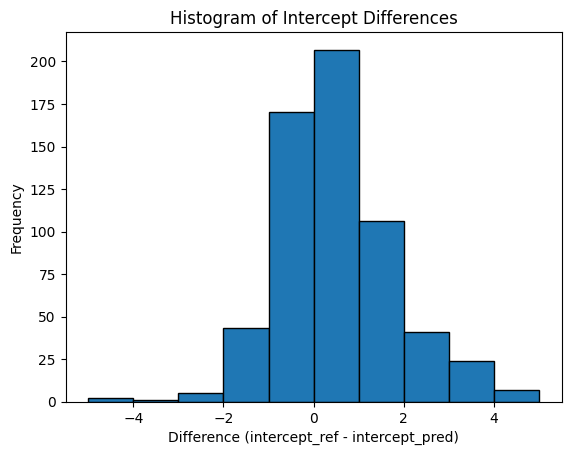

In [11]:
# Calculate bins based on binwidth=1
diff_clean = df['diff'].dropna()

min_val = diff_clean.min()
max_val = diff_clean.max()
bins = np.arange(min_val, max_val + 1, 1)  # binwidth = 1
plt.hist(diff_clean, bins=bins, edgecolor='black')
plt.xlabel('Difference (intercept_ref - intercept_pred)')
plt.ylabel('Frequency')
plt.title('Histogram of Intercept Differences')
plt.show()


In [12]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(0.0),
 np.float64(0.006600660066006601),
 np.float64(1.32363985848673))

In [12]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(0.8745874587458746),
 np.float64(2.228466710344847))

In [17]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(0.0),
 np.float64(0.4793388429752066),
 np.float64(1.9296363001585009))

In [19]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(0.0),
 np.float64(0.6970198675496688),
 np.float64(2.2466317651457346))

In [18]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(1.8039879312606584),
 np.float64(3.5291257233941966))

In [18]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(1.8251175244863649),
 np.float64(3.5445863540455935))

In [11]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(0.0),
 np.float64(-1.2586490939044481),
 np.float64(3.6515723120676493))

In [21]:
df['diff'].median(), df['diff'].mean(),df['diff'].std()

(np.float64(1.0),
 np.float64(1.316309719934102),
 np.float64(2.2321046816526913))

In [ ]:
picname = 'pic_07_13_01'

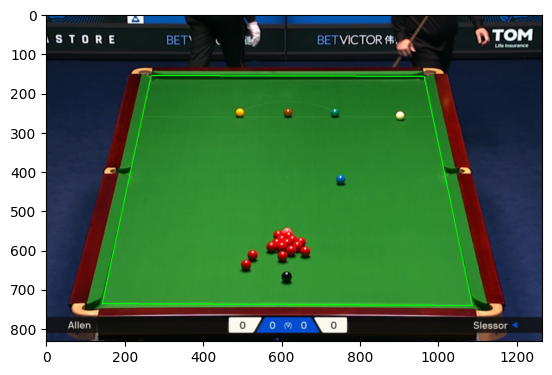

In [19]:
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')
data = polygon_annp.filter_by_image('pic_01_05_01.png')
points_gt = np.asarray(transform_annotation(pic, data.points))
display_img(plot_on_image(pic, polygons=[transform_annotation(pic, data.points)]))

pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb')

In [ ]:
transform_annotation(pic, data.points)

[Point(91.79939472546474, 647.2434608733248),
 Point(1034.6517509727623, 648.6984435797665),
 Point(909.9885970600949, 74.13343060959794),
 Point(221.12202766969295, 74.04507133592737)]

In [16]:
with open('playfield_gt/runda_5.json', 'r') as f:
    data = json.load(f)

In [20]:
with open('playfield_gt/ssss.json', 'w') as f:
    json.dump(data, f, indent=4)